# Nonsolobaschet Stats | 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display, HTML
from functools import reduce

from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
# Set the style globally
plt.style.use('default')
rcParams['font.weight'] = '500'
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.labelweight'] = '500'
rcParams['axes.titleweight'] = '600'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 12
rcParams['figure.titlesize'] = 18


### List of teams #########################################################
Teams = {'ale' : ['Sanfa','seagreen'],
         'enrico' : ['Gianlucanonpressare', 'darkorange'],
         'fabio' : ['Porti Chiusi Italiani', 'yellowgreen'],
         'gabriele' : ['Sciagura', 'r'],
         'gianluca' : ['La mamma di Enrico', 'midnightblue'],
         'luca' : ['Nottingham Forrest Gump', 'lightskyblue'],
        }

### Basic parameters ######################################################
parameters = [
    'fantapoints made',         # Fantapoints made
    'fantapoints against',        # Fantapoints against
    'goals against gk',     # Goals conceded by the goalkeeper that contributes to the team
    'cards',          # Cards against players that contribute to the team (yellow=1, red=2)
    'defense modifier',          # Modifier due to the performance of defensive players
]

### Global setup of the league #############################################
thr_first_goal = 66  # Threshold for first goal
step = 5   # Step between goal marks
thr_own_goal = 58    # Threshold for own goal
n_players = len(Teams)    # Number of players
low_score = 62    # Threshold for defining low scoring games (just for stats)

### Utility functions ################################################
def get_goal(fp_made, fp_against):
    '''Return number of goals given fantapoints'''
    goal_counter = 0
    if fp_against < thr_own_goal: goal_counter = goal_counter + 1
    if fp_made >= thr_first_goal: goal_counter = goal_counter + math.floor((fp_made-thr_first_goal)/step) + 1
    return goal_counter

def result(gf, gs):
    '''Return match result (W,T,L) given goal scored and conceded'''
    if gf > gs:
        return 'W'
    elif gf < gs:
        return 'L'
    else:
        return 'T'
    
def points(result):
    '''Return standing points given match result'''
    if result == 'W':
        return 3
    elif result == 'L':
        return 0
    elif result == 'T':
        return 1
    else:
        print('Non valid result')

def get_team_colors():
    '''Return list of team colors by default order'''
    colors = [Teams[key][1] for key in Teams.keys()]
    return colors
    
def fattore_distacco(Total):
    pf_med = np.median(Total['fantapoints made'])
    pf_std = np.std(Total['fantapoints made'])
    dist_med = np.median(Total['distacco'])
    dist_std = np.std(Total['distacco'])
    pf_rel = (Total['fantapoints made']-pf_med) / pf_std
    dist_rel = (Total['distacco']-dist_med) / dist_std
    return -dist_rel - pf_rel

def points_gaines_diff(fp_made, fp_against, pts):
    '''Returns points gained wrt the expected value given the difference in fantapoints'''
    diff = fp_made - fp_against
    if diff < -step:
        exp_points = 0
    elif diff >= step:
        exp_points = 3
    elif diff >= -step and diff < 0:
        exp_points = 1 + diff/step
    elif diff >= 0 and diff < step:
        exp_points = 1 + 2*diff/step
    return pts - exp_points 

def points_gained_day(gf, pts, matchday):
    '''Returns points gained wrt expected value considering fantapoints made by other players that matchday'''
    exp_points = 0
    for team in teams:
        exp_points = exp_points + points(result(gf,df_final[df_final['team']==team].at[matchday,'GM']))
    return pts - (exp_points-1) / (n_players-1)  # -1 to eliminate the case when a player is against him/herself

def compact_res(res_str):
    '''Returns something of the form 3W,1T,2L from a string of the form WLTLWWL'''
    n_w, n_t, n_l = 0, 0, 0
    for c in res_str:
        if (c == 'W'):
            n_w = n_w + 1
        elif (c == 'T'):
            n_t = n_t + 1
        elif (c == 'L'):
            n_l = n_l + 1
        else:
            print('Non valid result')
    return f'{n_w}W,{n_t}T,{n_l}L'

# >>> Scores txt files <<<

### Gianluca | La mamma di Enrico

In [5]:
%%writefile gianluca.txt
gg pf ps gs c mdif
1 82 77.5 1 1 1
2 63.5 67 1 3 0
3 68.5 79 1 1 0
4 79.5 76.5 0 2 3
5 69.5 77 1 1 1
6 75 65 0 1 1
7 71.5 69.5 1 1 0
8 74.5 80 0 2 1
9 70.5 82.5 1 1 1
10 60 69 2 1 0
11 64 65 1 1 1
12 69.5 71.5 2 3 1

Overwriting gianluca.txt


### Fabio | Porti Chiusi Italiani

In [4]:
%%writefile fabio.txt
gg pf ps gs c mdif
1 77 72 3 3 0
2 67.5 57.5 1 2 0
3 79 68.5 4 2 0
4 69.5 78.5 2 2 0
5 77 68 1 3 0
6 65 70 1 3 0
7 69.5 71.5 0 0 0
8 64.5 70.5 0 1 0
9 82 62 1 2 0
10 68 82 4 1 0
11 65 75.5 1 3 1
12 71.5 69.5 0 2 0

Overwriting fabio.txt


### Enrico | Gianlucanonpressare

In [6]:
%%writefile enrico.txt
gg pf ps gs c mdif
1 79.5 61 1 2 3
2 57.5 67.5 2 4 0
3 76 78 0 3 1
4 76 78.5 1 2 1
5 72.5 71 0 2 1
6 70 65 1 3 1
7 73 74.5 2 4 1
8 80 74.5 0 2 1
9 82 76 2 2 3
10 83 66.5 0 3 0
11 75.5 65 2 2 3
12 69.5 76.5 0 1 1

Overwriting enrico.txt


### Gabriele | Sciagura

In [18]:
%%writefile gabriele.txt
gg pf ps gs c mdif
1 72 77 0 1 1
2 72 74.5 0 3 3
3 78 76 1 2 1
4 76.5 79.5 3 2 0
5 68 77 2 3 1
6 74.5 73.5 1 6 1
7 74.5 73 1 3 0
8 73 71 1 3 1
9 82.5 70.5 0 2 1
10 82 68 1 1 1
11 71.5 73 0 2 1
12 76.5 69.5 1 4 3

Overwriting gabriele.txt


### Luca | Nottingham Forrest Gump

In [19]:
%%writefile luca.txt
gg pf ps gs c mdif
1 77.5 82 0 1 3
2 74.5 72 2 1 1
3 80.5 77 0 0 1
4 78.5 76 0 3 1
5 77 69.5 1 1 1
6 73.5 74.5 0 0 1
7 76.5 66 1 2 1
8 70.5 64.5 2 3 1
9 76 82 0 2 1
10 69 60 0 2 1
11 73 71.5 1 5 3
12 65.5 61 1 2 1

Overwriting luca.txt


### Ale | Sanfa

In [20]:
%%writefile ale.txt
gg pf ps gs c mdif
1 61 79.5 2 1 0
2 67 63.5 1 0 0
3 77 80.5 3 4 0
4 78.5 69.5 1 0 0
5 71 72.5 1 1 0
6 65 75 4 5 0
7 66 76.5 2 1 0
8 71 73 0 2 1
9 62 82 3 4 0
10 66.5 83 0 1 0
11 65 64 2 2 0
12 61 65.5 3 2 0

Overwriting ale.txt


# >>> Fill dataframe <<<

In [21]:
teams = list(Teams.keys())

### Fill dataframe with data #####################################
df_list = list()
for team in teams:
    df_result = pd.read_csv(f'{team}.txt', sep=' ', names=parameters, skiprows=1)
    df_result['team'] = team
    df_list.append(df_result)
df_final = reduce(lambda a, b : a.append(b), df_list)
df_final.index.name = 'Game'

# Adding columns to the dataframe
df_final['GM'] = df_final.apply(lambda x: get_goal(x['fantapoints made'], x['fantapoints against']), axis=1)
df_final['GA'] = df_final.apply(lambda x: get_goal(x['fantapoints against'], x['fantapoints made']), axis=1)
df_final['result'] = df_final.apply(lambda x: result(x['GM'], x['GA']), axis=1)
df_final['points'] = df_final.apply(lambda x: points(x['result']), axis=1)
df_final['f_close_games'] = round(
    df_final.apply(lambda x: points_gaines_diff(x['fantapoints made'], x['fantapoints against'],x['points']), axis=1), 3)
df_final['f_day_average'] = round(df_final.apply(lambda x: points_gained_day(x['GM'],x['points'],x.name), axis=1), 3)
df_final['Luck Index'] = round(df_final['f_close_games'] + df_final['f_day_average'], 3)

### Global variables and stats #############################
games = max(df_final.index)   # Total number of matchdays
fp_mean = np.mean(df_final['fantapoints made'])
fp_med = np.median(df_final['fantapoints made'])
fp_std = np.std(df_final['fantapoints made'])
gm_mean = np.mean(df_final['GM'])
gm_med = np.median(df_final['GM'])
gm_std = np.std(df_final['GM'])
print('### CUMULATIVE DATA after', games, 'rounds ###')
print('Fantapoints made:\n average =', fp_mean, '\n median =', fp_med, '\n standard deviation =', fp_std, 
      '\nGoals made:\n average =', gm_mean, '\n median =', gm_med, '\n standard deviation =', gm_std
     )

### Personal stats #####################################
personal_average = {}
for team, new_df in df_final.groupby(['team']):
    personal_average[team] = np.mean(new_df['fantapoints made'])
print('\n Personal Averages (Fantapoints):')
display(personal_average)


### CUMULATIVE DATA after 12 rounds ###
Fantapoints made:
 average = 72.25 
 median = 72.25 
 standard deviation = 6.089608635481704 
Goals made:
 average = 1.8611111111111112 
 median = 2.0 
 standard deviation = 1.2282050538574525

 Personal Averages (Fantapoints):


{'ale': 67.58333333333333,
 'enrico': 74.54166666666667,
 'fabio': 71.29166666666667,
 'gabriele': 75.08333333333333,
 'gianluca': 70.66666666666667,
 'luca': 74.33333333333333}

In [22]:
### Display data divided by player

print('### PERSONAL DATA ###\n')

for team, new_df in df_final.groupby(['team']):
    print('Team:', Teams[team][0], '(',team,')')
    display(new_df.drop(['team'], axis=1))
    print('\n\n')

### PERSONAL DATA ###

Team: Sanfa ( ale )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,61.0,79.5,2,1,0,0,3,L,0,0.0,0.0,0.0
2,67.0,63.5,1,0,0,1,0,W,3,0.6,1.8,2.4
3,77.0,80.5,3,4,0,3,3,T,1,0.7,-0.4,0.3
4,78.5,69.5,1,0,0,3,1,W,3,0.0,1.6,1.6
5,71.0,72.5,1,1,0,2,2,T,1,0.3,-0.4,-0.1
6,65.0,75.0,4,5,0,0,2,L,0,0.0,-0.2,-0.2
7,66.0,76.5,2,1,0,1,3,L,0,0.0,-0.2,-0.2
8,71.0,73.0,0,2,1,2,2,T,1,0.4,-0.6,-0.2
9,62.0,82.0,3,4,0,0,4,L,0,0.0,0.0,0.0





Team: Gianlucanonpressare ( enrico )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,79.5,61.0,1,2,3,3,0,W,3,0.0,1.4,1.4
2,57.5,67.5,2,4,0,0,2,L,0,0.0,-0.2,-0.2
3,76.0,78.0,0,3,1,3,3,T,1,0.4,-0.4,0.0
4,76.0,78.5,1,2,1,3,3,T,1,0.5,-0.4,0.1
5,72.5,71.0,0,2,1,2,2,T,1,-0.6,-0.4,-1.0
6,70.0,65.0,1,3,1,1,0,W,3,0.0,1.8,1.8
7,73.0,74.5,2,4,1,2,2,T,1,0.3,-0.6,-0.3
8,80.0,74.5,0,2,1,3,2,W,3,0.0,0.0,0.0
9,82.0,76.0,2,2,3,4,3,W,3,0.0,0.8,0.8





Team: Porti Chiusi Italiani ( fabio )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,77.0,72.0,3,3,0,3,2,W,3,0.0,1.4,1.4
2,67.5,57.5,1,2,0,2,0,W,3,0.0,0.8,0.8
3,79.0,68.5,4,2,0,3,1,W,3,0.0,1.6,1.6
4,69.5,78.5,2,2,0,1,3,L,0,0.0,0.0,0.0
5,77.0,68.0,1,3,0,3,1,W,3,0.0,0.4,0.4
6,65.0,70.0,1,3,0,0,1,L,0,0.0,-0.2,-0.2
7,69.5,71.5,0,0,0,1,2,L,0,-0.6,-0.2,-0.8
8,64.5,70.5,0,1,0,0,1,L,0,0.0,0.0,0.0
9,82.0,62.0,1,2,0,4,0,W,3,0.0,0.8,0.8





Team: Sciagura ( gabriele )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,72.0,77.0,0,1,1,2,3,L,0,0.0,-0.6,-0.6
2,72.0,74.5,0,3,3,2,2,T,1,0.5,-1.2,-0.7
3,78.0,76.0,1,2,1,3,3,T,1,-0.8,-0.4,-1.2
4,76.5,79.5,3,2,0,3,3,T,1,0.6,-0.4,0.2
5,68.0,77.0,2,3,1,1,3,L,0,0.0,-0.2,-0.2
6,74.5,73.5,1,6,1,2,2,T,1,-0.4,-1.2,-1.6
7,74.5,73.0,1,3,0,2,2,T,1,-0.6,-0.6,-1.2
8,73.0,71.0,1,3,1,2,2,T,1,-0.8,-0.6,-1.4
9,82.5,70.5,0,2,1,4,1,W,3,0.0,0.8,0.8





Team: La mamma di Enrico ( gianluca )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,82.0,77.5,1,1,1,4,3,W,3,0.2,0.0,0.2
2,63.5,67.0,1,3,0,0,1,L,0,-0.3,-0.2,-0.5
3,68.5,79.0,1,1,0,1,3,L,0,0.0,0.0,0.0
4,79.5,76.5,0,2,3,3,3,T,1,-1.2,-0.4,-1.6
5,69.5,77.0,1,1,1,1,3,L,0,0.0,-0.2,-0.2
6,75.0,65.0,0,1,1,2,0,W,3,0.0,0.8,0.8
7,71.5,69.5,1,1,0,2,1,W,3,1.2,1.4,2.6
8,74.5,80.0,0,2,1,2,3,L,0,0.0,-1.6,-1.6
9,70.5,82.5,1,1,1,1,4,L,0,0.0,-0.6,-0.6





Team: Nottingham Forrest Gump ( luca )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,77.5,82.0,0,1,3,3,4,L,0,-0.1,-1.6,-1.7
2,74.5,72.0,2,1,1,2,2,T,1,-1.0,-1.2,-2.2
3,80.5,77.0,0,0,1,3,3,T,1,-1.4,-0.4,-1.8
4,78.5,76.0,0,3,1,3,3,T,1,-1.0,-0.4,-1.4
5,77.0,69.5,1,1,1,3,1,W,3,0.0,0.4,0.4
6,73.5,74.5,0,0,1,2,2,T,1,0.2,-1.2,-1.0
7,76.5,66.0,1,2,1,3,1,W,3,0.0,0.0,0.0
8,70.5,64.5,2,3,1,1,0,W,3,0.0,2.4,2.4
9,76.0,82.0,0,2,1,3,4,L,0,0.0,-1.2,-1.2


In [23]:
### Total dataframe with sums
df_total = df_final.groupby(['team']).apply(lambda x: x.sum())
df_total['results'] = df_total.apply(lambda x: compact_res(x['result']), axis=1)

### Order by points (and then fantapoints) -> Build classification
cols = ['points', 'fantapoints made']
tups = df_total[cols].sort_values(cols, ascending=False).apply(tuple, 1)
f, i = pd.factorize(tups)
factorized = pd.Series(f + 1, tups.index)
df_total['pos'] = factorized

df_total['rank'] = df_total['fantapoints made'].rank(ascending=False, method='first').astype(int)
df_total['distance'] = np.max(df_total['points']) - df_total['points']
print('### Cumulative data after', games, 'games ###')
param=['pos', 'points', 'distance', 'fantapoints made', 'rank', 'fantapoints against',
       'results', 'GM', 'GA', 'goals against gk',
      'cards', 'defense modifier', 'f_close_games', 'f_day_average', 'Luck Index'
      ] # Parameters to display
display(df_total[param].sort_values(by=['points', 'fantapoints made'], ascending=False))

### Data of the last matchday
print('\n### Data matchday number', games, ' ###')
df_last_day = df_final[df_final.index==games]
df_last_day.set_index('team', inplace=True)
display(df_last_day)

### Cumulative data after 12 games ###


,pos,points,distance,fantapoints made,rank,fantapoints against,results,GM,GA,goals against gk,cards,defense modifier,f_close_games,f_day_average,Luck Index
team,,,,,,,,,,,,,,,
enrico,1,22,0,894.5,2,854.0,"6W,4T,2L",28,21,11,30,16,0.6,1.8,2.4
luca,2,18,4,892.0,3,856.0,"4W,6T,2L",26,22,8,22,16,-5.7,-1.6,-7.3
fabio,3,18,4,855.5,4,845.5,"6W,0T,6L",20,18,18,24,1,0.6,3.8,4.4
gabriele,4,16,6,901.0,1,882.5,"3W,7T,2L",30,25,11,32,14,-1.2,-5.2,-6.4
gianluca,5,11,11,848.0,5,879.5,"3W,2T,7L",17,24,11,18,10,-0.5,-1.6,-2.1
ale,6,11,11,811.0,6,884.5,"2W,5T,5L",13,24,22,23,1,2.5,2.0,4.5



### Data matchday number 12  ###


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
team,,,,,,,,,,,,
ale,61.0,65.5,3,2,0,0,0,T,1,0.9,0.8,1.7
enrico,69.5,76.5,0,1,1,1,3,L,0,0.0,-1.4,-1.4
fabio,71.5,69.5,0,2,0,2,1,W,3,1.2,0.6,1.8
gabriele,76.5,69.5,1,4,3,3,1,W,3,0.0,0.0,0.0
gianluca,69.5,71.5,2,3,1,1,2,L,0,-0.6,-1.4,-2.0
luca,65.5,61.0,1,2,1,0,0,T,1,-1.8,0.8,-1.0


# [>] Points and Goals vs Expected values

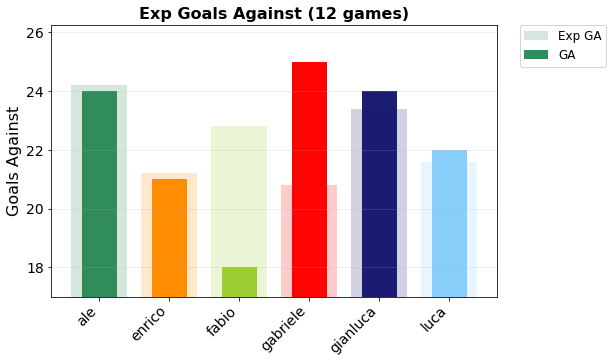

In [24]:
### Expected value of goals against, facing all other opponents ##############################à
df_total['x_GA'] = (df_total['GM'].sum()-df_total['GM']) / (n_players-1)

fig = plt.figure(figsize=(8,5))

colors = get_team_colors()

plt.bar(np.arange(0, n_players), df_total['x_GA'], color=colors, alpha=0.2, label='Exp GA')
plt.bar(np.arange(0, n_players), df_total['GA'], color=colors, alpha=0.99, width=0.5, label='GA')
xlabels = teams
plt.xticks(np.arange(n_players), teams, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

plt.ylim(bottom = min(df_total['GA']-1))
plt.ylabel('Goals Against')
title = 'Exp Goals Against (' + str(games) + ' games)'
plt.title(title)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

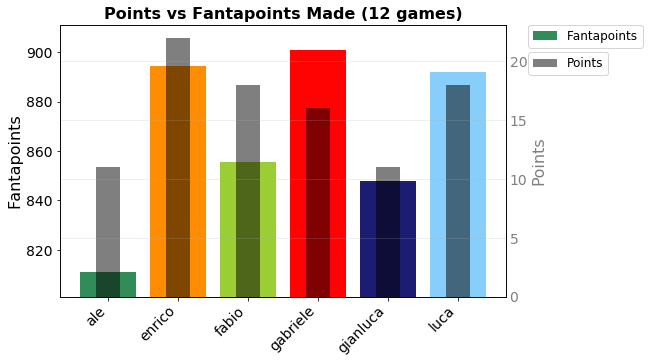

In [25]:
### Fantapoints made vs classification ###############
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()

plt.bar(np.arange(0, n_players), df_total['fantapoints made'], color=colors, alpha=0.99, label='Fantapoints')


plt.ylabel('Fantapoints')
plt.ylim(np.min(df_total['fantapoints made'])-10, np.max(df_total['fantapoints made'])+10)
xlabels = teams
plt.xticks(np.arange(n_players), xlabels, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# secondary y axis
ax2 = plt.twinx()
ax2.set_ylabel('Points')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.bar(np.arange(0, n_players), df_total['points'], color='black', alpha=0.5, width=0.35, label='Points')

plt.grid(which='both', axis='y', alpha=0.25)

title = 'Points vs Fantapoints Made (' + str(games) + ' games)'
plt.title(title)

ax2.legend(bbox_to_anchor=(1.05, 0.9), loc=2, borderaxespad=0.)

plt.show()

# <<<<< Luck Index >>>>>

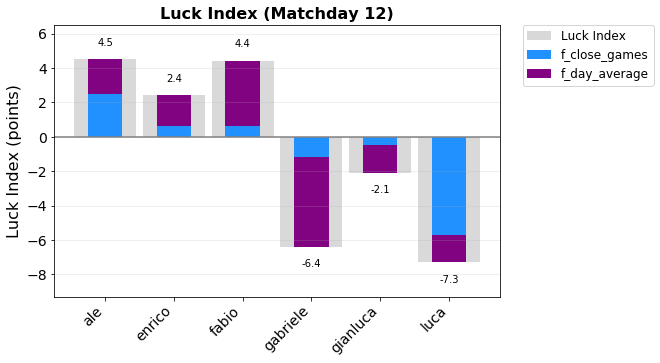

In [26]:
keys = ('f_close_games', 'f_day_average')  # Factors contributing to Luck Index
cols = ['dodgerblue', 'purple']

fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = teams
plt.xticks(np.arange(n_players), xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

plt.bar(np.arange(n_players), df_total['Luck Index'], color='black', lw=0, alpha=0.15, width=0.9, label='Luck Index')
plt.bar(np.arange(n_players), df_total[keys[0]], color=cols[0] ,alpha=0.99, width=0.5, label=keys[0])
plt.bar(np.arange(n_players), df_total[keys[1]],
        bottom=np.heaviside(df_total[keys[1]]*df_total[keys[0]],0.5)*df_total[keys[0]],
        color=cols[1] ,alpha=0.99, width=0.5, label=keys[1])  # Bottom different from 0 for piling up bars in a proper way

plt.legend()

for i, f in enumerate(list(np.round(df_total['Luck Index'], decimals=2))):
    if f<0:
        va = 'top'
        offset = -0.7
    else: 
        va = 'bottom'
        offset = 0.7
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va)
    
plt.ylim(min(df_total['Luck Index'])-2, max(df_total['Luck Index'])+2)

plt.ylabel('Luck Index (points)')
title = 'Luck Index (Matchday ' + str(games) + ')'
plt.title(title)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [27]:
### Evolution plots #####################################

def evo_plot(par, title, ylabel, threshold):
    gms = np.arange(1, games+1)
    fig = plt.figure(figsize=(games*0.6,6))

    data = []
    for team in teams:
        df = df_final[df_final['team']==team].copy()
        df['cumsum'] = np.cumsum(df[par])
        score = df['cumsum'].loc[games]
        df['score'] = score
        data.append(df)
    data = sorted(data, key=lambda x: x['score'].unique().min(axis=0), reverse=True)

    for df in data:
        team = df['team'].unique()[0]
        color = Teams[team][1]
        df['cumsum'] = round(np.cumsum(df[par]), 3)
        score = df['cumsum'].loc[games]
        score_prev = df['cumsum'].loc[games-1]
        diff = round(score - score_prev,3)
        if diff >= 0:
            sign = '+'
        else:
            sign = ''
        p = plt.plot(gms, df['cumsum'], color=color, ls='-', lw=2,
                     label=str(score)+' ('+ sign + str(diff)+') | '+str(team))

        # Labels for games over threshold
        gm = df[(df[par]>threshold)|(df[par]<-threshold)].index
        dd = df[df.index.isin(gm)]
        marks = dd['cumsum']
        plt.scatter(gm, marks, edgecolor=color, facecolor=color, s=400+20*dd[par], label='')
        for x, y, text in zip(gm, marks, dd[par]):
            plt.text(x, y, text, horizontalalignment='center', verticalalignment='center', color='white')

    plt.xticks(np.arange(0, games+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.grid(axis='y', alpha=0.2)
    plt.xlabel('Matchday')
    plt.ylabel(ylabel)
    plt.title(title, fontsize=20)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

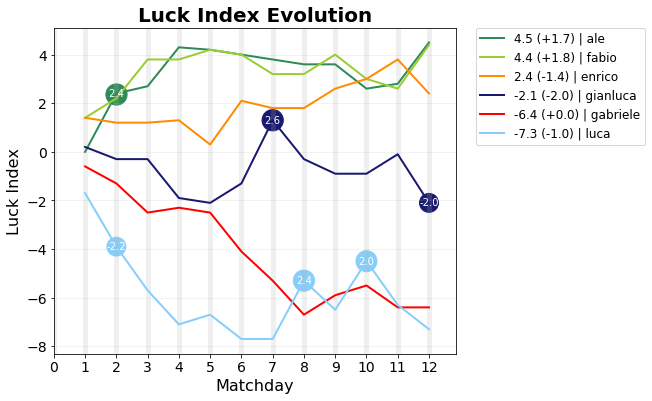

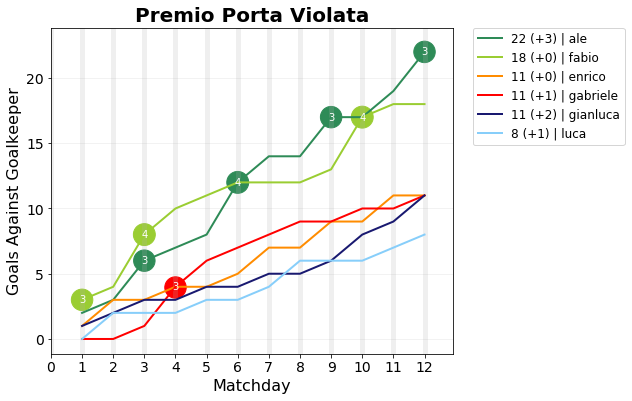

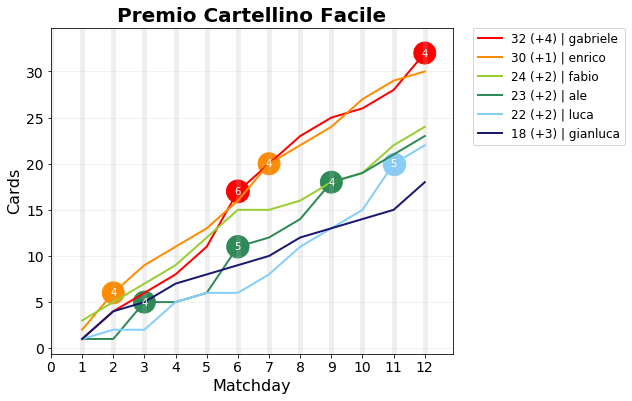

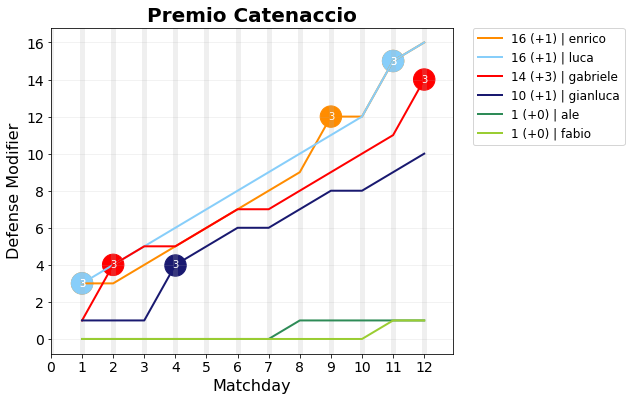

In [28]:
evo_plot(par='Luck Index', title='Luck Index Evolution', ylabel='Luck Index', threshold=1.9)
evo_plot(par='goals against gk', title='Premio Porta Violata', ylabel='Goals Against Goalkeeper', threshold=2)
evo_plot(par='cards', title='Premio Cartellino Facile', ylabel='Cards', threshold=3)
evo_plot(par='defense modifier', title='Premio Catenaccio', ylabel='Defense Modifier', threshold=2) 

# [>] Box plots

In [29]:
### Melt dataframe with variables of interest ######################
def melt_df(variables = ['fantapoints against', 'fantapoints made']):
    data = []
    for team in teams:
        df=df_final[df_final['team']==team].copy()
        dd = pd.DataFrame()
        dd['Team'] = df_final[df_final['team']==team]['team']
        for key in variables:
            dd[key] = df[key]
        data.append(dd)
    cdf = pd.concat(data)    
    mdf = pd.melt(cdf, id_vars=['Team'], var_name=['Variable'])
    return mdf

In [30]:
### Box Plots #################################################
def box_plot(par, label, title, col, pal):
    data = melt_df([par])

    # Box plot
    ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color=col, whis=1.5, width=0.5)    
    # Draw single datapoints
    ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette=pal)    

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ymin, ymax = ax.get_ylim()
    goal_marks = np.array([thr_own_goal])
    goal_numb = np.array([0])
    for i in range(0, math.floor((ymax-thr_first_goal) / step) + 2):
            goal_marks = np.append(goal_marks, [thr_first_goal + i*step])
            goal_numb = np.append(goal_numb, i+1)
    goal_numb = np.insert(goal_numb, 0, -1)
    ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    ax.hlines(goal_marks, -1000, 1000, 'grey', '-', linewidth=1, alpha=0.5)
    ax.hlines(fp_med, -100, 100, colors='red', linewidth=1, linestyles='--', alpha=0.5, label='Median')


    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Secondary y axis
    ax2 = ax.twinx()
    goal = lambda fp_made: (fp_made-66) / step + 0.5
    ax2.set_ylim((goal(ymin), goal(ymax)))
    ax2.set_yticks(goal_numb)
    yticks = goal_numb.tolist()
    yticks[0] = 'Own goal\nthreshold'
    ax2.set_yticklabels(yticks)
    ax2.set_ylabel('Goals')
    ax2.tick_params(axis='y', colors='grey', length=0)
    ax2.yaxis.label.set_color('grey')
    ax2.plot([],[])

    plt.title(title, fontsize=20)
    plt.show()

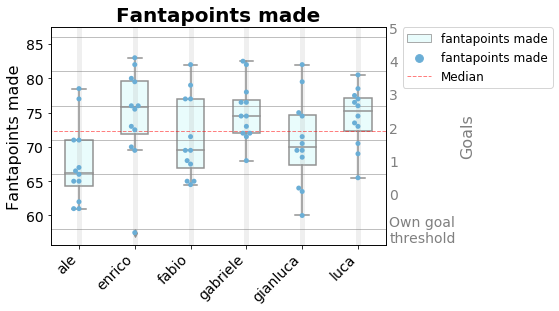

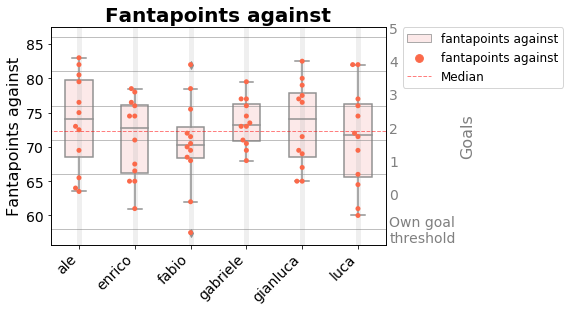

In [31]:
box_plot(par='fantapoints made', label= 'Fantapoints made', title='Fantapoints made', col='cyan', pal='Blues')
box_plot(par='fantapoints against', label= 'Fantapoints against', title='Fantapoints against', col='r', pal='Reds')

# [>] Grahical display of results

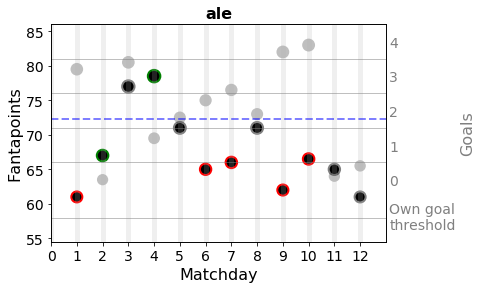

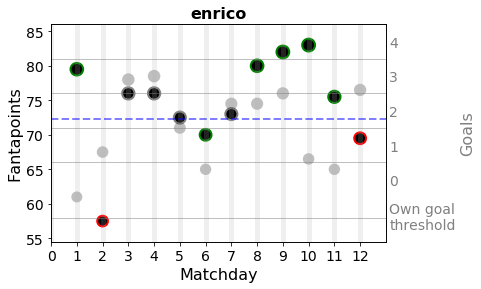

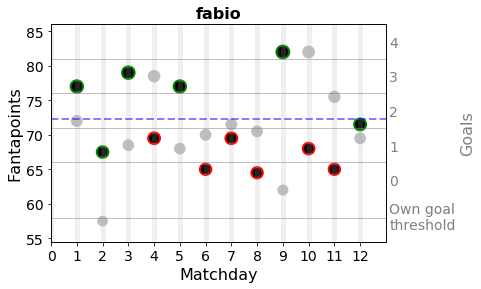

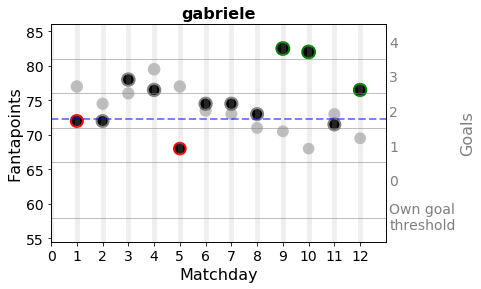

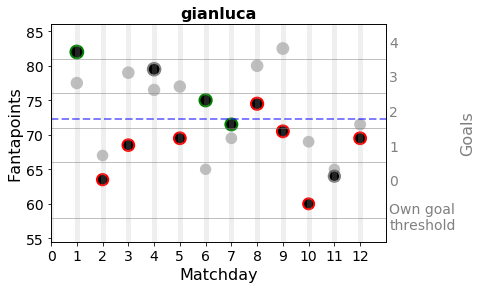

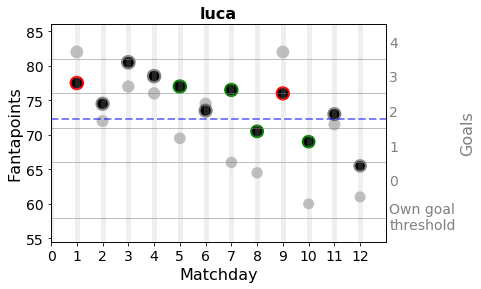

In [32]:
### Graphical display of results ######################################################
for team in teams: 
    data_team = df_final[df_final['team']==team].copy()  
    fig = plt.figure(figsize=(games*0.5, 4))

    # Losses
    data = data_team[data_team.result == 'L']
    ax = plt.scatter(data.index, data['fantapoints made'], c='black', edgecolor='r',
                     linewidth=2, s=data['fantapoints made']*2, label='')
    ax = plt.scatter(data.index, data['fantapoints against'], c='black', edgecolor='none',
                     s=data['fantapoints against']*2, alpha=0.25, label='')
    # Ties
    data = data_team[data_team.result == 'T']
    ax = plt.scatter(data.index, data['fantapoints made'], c='black', edgecolor='grey',
                     linewidth=2, s=data['fantapoints made']*2, label='')
    ax = plt.scatter(data.index, data['fantapoints against'], c='black', edgecolor='none',
                     s=data['fantapoints against']*2, alpha=0.25, label='')
    # Wins
    data = data_team[data_team.result == 'W']
    ax = plt.scatter(data.index, data['fantapoints made'], c='black', edgecolor='g',
                     linewidth=2, s=data['fantapoints made']*2, label='')
    ax = plt.scatter(data.index, data['fantapoints against'], c='black', edgecolor='none',
                     s=data['fantapoints against']*2, alpha=0.25, label='')
    
    # Setting limits y-axis and adding line for goal marks and median
    ymin = min(df_final['fantapoints made'].min(), df_final['fantapoints against'].min()) - 3
    ymax = max(df_final['fantapoints made'].max(), df_final['fantapoints against'].max()) + 3
    goal_marks = np.array([thr_own_goal])
    goal_numb = np.array([0])
    for i in range(0, math.floor((ymax-thr_first_goal) / step) + 2):
        goal_marks = np.append(goal_marks,[thr_first_goal + i*step])
        goal_numb = np.append(goal_numb, i + 1)
    goal_numb = np.insert(goal_numb, 0, -1)
    plt.hlines(goal_marks, -1000, 1000, 'grey', '-', linewidth=1, alpha=0.5)
    plt.hlines(fp_med, 0, 40, colors='blue', linewidth=2, linestyles='--', alpha=0.5, label='Median')
    
    plt.xlabel('Matchday')
    plt.ylabel('Fantapoints')
    plt.title(team)

    plt.xlim(0, games + 1)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(0, games + 1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    
    # Secondary y axis
    ax2 = plt.twinx()  
    goal = lambda fp_made: (fp_made-66) / step + 0.5 
    ax2.set_yticks(goal_numb)
    yticks = goal_numb.tolist()
    yticks[0] = 'Own goal\nthreshold'
    ax2.set_yticklabels( yticks)
    ax2.set_ylabel('Goals')
    ax2.set_ylim((goal(ymin), goal(ymax)))
    ax2.tick_params(axis='y', colors='grey', length=0)
    ax2.yaxis.label.set_color('grey')
    ax2.plot([],[])
  
    plt.show()